In [218]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression
%matplotlib inline
from statsmodels.formula.api import ols
import numpy as np
import src
import random
import scipy.stats as stats



# Methodology

My approach to this model was to do some eda to find strongly correlated variables, then work from the ground up to add features one at a time and see their effect. As such this notebook includes a ton of different iterations of the model, but I did not want to deviate its structure too much from my though process. 

In [219]:
df = pd.read_csv("kc_house_data_train.csv")
fedfunds = pd.read_csv("fedfunds")
fedfunds['year_month'] = fedfunds['year_month'].astype(str)
df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,...,8,2070,0,1986,0,98058,47.4388,-122.162,2390,7700
1,1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,...,8,1830,1070,1977,0,98115,47.6784,-122.285,2370,6283
2,2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,...,11,3770,0,1997,0,98006,47.5646,-122.129,3710,9685
3,3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,...,12,4560,0,1990,0,98034,47.6995,-122.228,4050,14226
4,4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,...,9,2550,0,2004,0,98052,47.6647,-122.083,2250,4050


[(0, 2985984)]

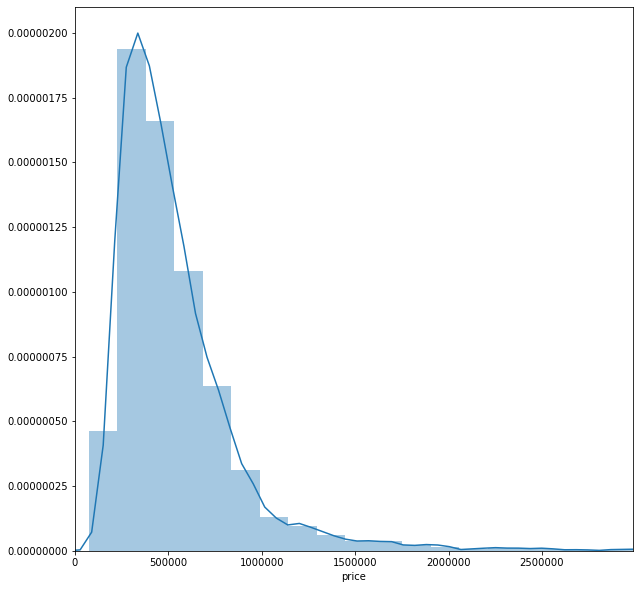

In [220]:
fig2, axes = plt.subplots( figsize = (10,10))
ax = sns.distplot(df.price)
ax.set(xlim = (0,12**6))


There are alot of outlier prices, cannot do too much to alter these as price is the target variable, but it may negatively effect the model. 

In [221]:
df.corr()

,Unnamed: 0,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
Unnamed: 0,1.000000e+00,-0.006139,-0.012306,-0.010271,-0.004940,-0.008900,-0.003500,0.010599,-0.008845,-6.278161e-07,...,-0.005015,-0.003406,-0.012104,0.007496,-0.003423,0.006218,0.002470,-0.006992,-0.008961,0.000463
id,-6.138777e-03,1.000000,-0.015644,-0.001529,0.003833,-0.014251,-0.129837,0.017126,0.000101,1.259374e-02,...,0.003163,-0.013932,-0.003516,0.013697,-0.019560,-0.008166,-0.001865,0.017388,-0.007494,-0.139605
price,-1.230630e-02,-0.015644,1.000000,0.305106,0.524335,0.703540,0.086803,0.256985,0.275779,3.954851e-01,...,0.666215,0.607760,0.323312,0.056450,0.117770,-0.048958,0.302394,0.019327,0.585567,0.081423
bedrooms,-1.027127e-02,-0.001529,0.305106,1.000000,0.507867,0.570428,0.029375,0.172975,-0.008581,7.974076e-02,...,0.354679,0.472492,0.300085,0.153769,0.013679,-0.147515,-0.002170,0.124279,0.387589,0.026665
bathrooms,-4.939574e-03,0.003833,0.524335,0.507867,1.000000,0.755270,0.085470,0.497967,0.065848,1.888170e-01,...,0.664191,0.686853,0.282700,0.507761,0.048140,-0.201527,0.023074,0.221308,0.568080,0.086499
sqft_living,-8.900440e-03,-0.014251,0.703540,0.570428,0.755270,1.000000,0.166810,0.357169,0.109738,2.833358e-01,...,0.762929,0.876696,0.435529,0.319397,0.051448,-0.195893,0.052646,0.234453,0.755066,0.179570
sqft_lot,-3.500101e-03,-0.129837,0.086803,0.029375,0.085470,0.166810,1.000000,-0.002205,0.015356,7.305841e-02,...,0.110320,0.180755,0.008065,0.054228,0.004520,-0.126590,-0.082029,0.226190,0.136959,0.701875
floors,1.059874e-02,0.017126,0.256985,0.172975,0.497967,0.357169,-0.002205,1.000000,0.025132,2.588299e-02,...,0.458984,0.528509,-0.247481,0.483657,0.005985,-0.060560,0.048227,0.128795,0.283933,-0.008170
waterfront,-8.844970e-03,0.000101,0.275779,-0.008581,0.065848,0.109738,0.015356,0.025132,1.000000,4.075653e-01,...,0.092234,0.077162,0.083433,-0.021981,0.094268,0.034282,-0.013331,-0.042728,0.091090,0.026895
view,-6.278161e-07,0.012594,0.395485,0.079741,0.188817,0.283336,0.073058,0.025883,0.407565,1.000000e+00,...,0.249554,0.164747,0.279939,-0.049593,0.091291,0.089475,0.003820,-0.077572,0.279999,0.073185


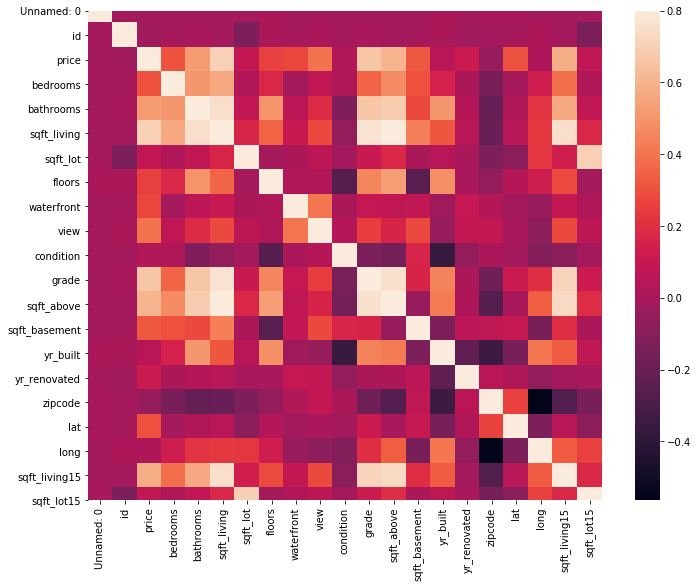

In [222]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

This is an initial exploration of the correlation table, trying to pick out features which are crucial and ones that can be reomved. Sqft seems to affect price across the board. View and water front dont correlate as much as I would have thought.  

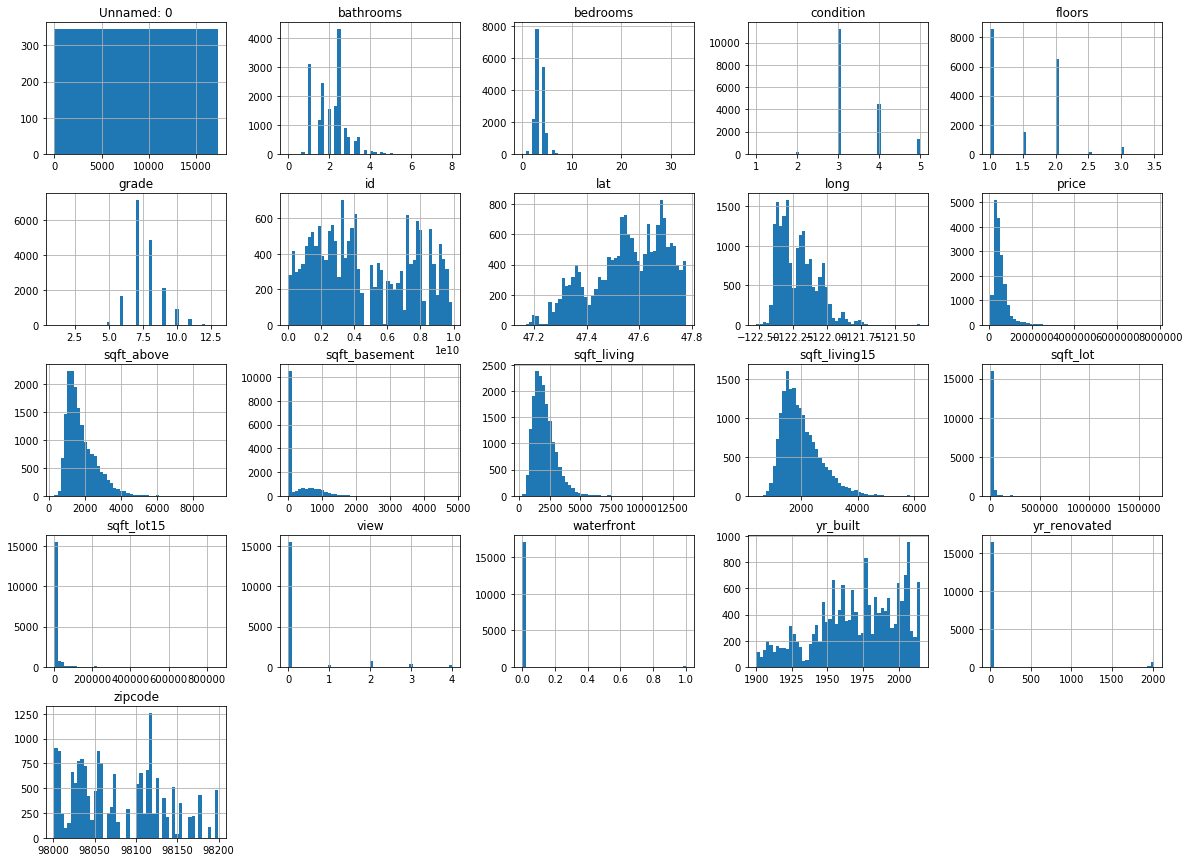

In [223]:
df.hist(bins=50, figsize=(20,15))
plt.show()

These histograms show some more outliers. I found the yr built graph fascinating since it shows how much building has dropped since and spiked over time. Year renovated is 0 for almost every datapoints which I think means the house has never been renovated, not that it was renovated 2000 years ago by Jesus himself. All the sqft measures, bedrooms and bathrooma are skewed to the right, I think lowering some of these outliers will help the model but I end up experimenting both ways. 

In [224]:
def remove_outliers(x):
    std = x.std()
    two_std = x.mean() + 3*std
    return np.where(x < two_std, x, two_std)

In [225]:
df['sqft_living_n'] = remove_outliers(df.sqft_living)
df['bedrooms_n'] = remove_outliers(df.bedrooms)
df['sqft_above_n'] = remove_outliers(df.sqft_above)

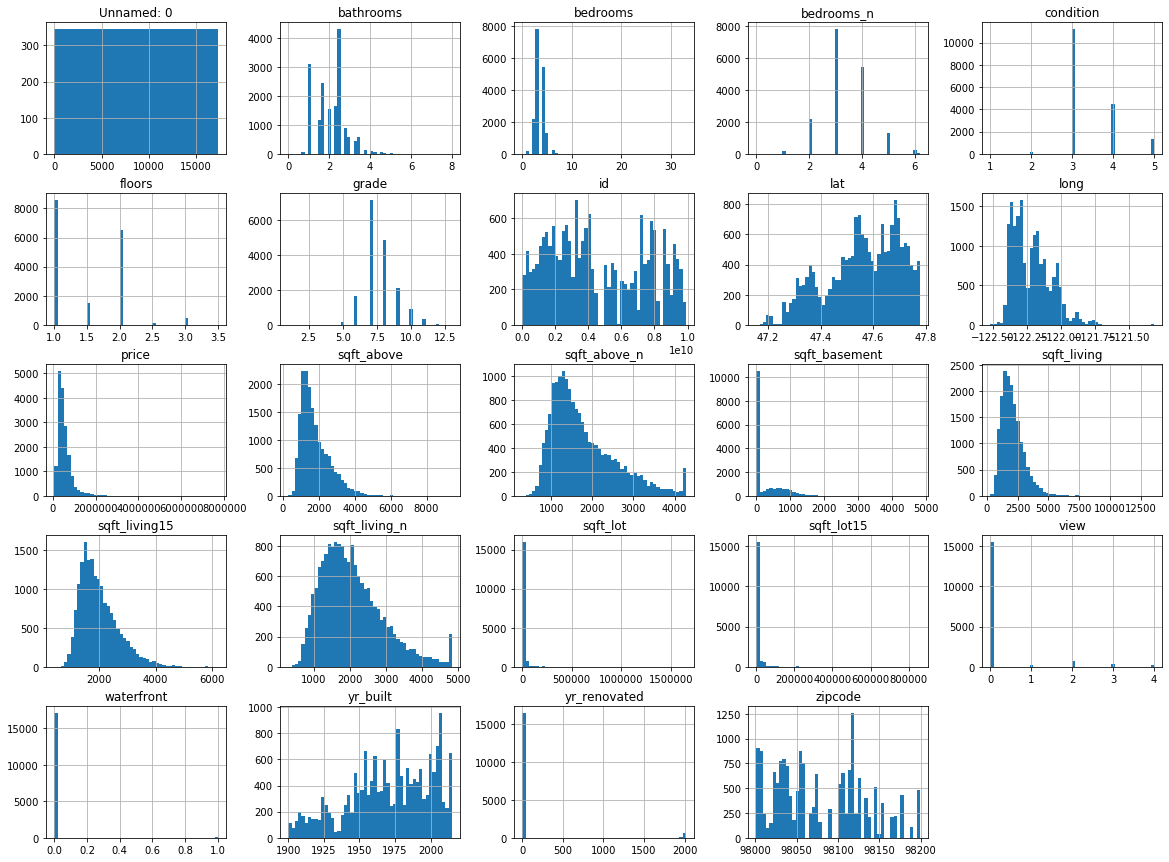

In [226]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [227]:
df.waterfront.value_counts()

0    17152
1      138
Name: waterfront, dtype: int64

Already seems to be a dummy variable, where 1 is yes and 0 is no. Lets run a t-test at a signifigance level of .05 to make sure this is a significant variable.  
  
*Null Hypothesis:* There is no difference between the average price of waterfront properties and non waterfront properties.  

*Alternative Hypothesis:* There is a significant difference in average price of waterfron properties and non waterfront properties.   


In [228]:
from scipy.stats import ttest_ind

waterfront = df[df['waterfront'] == 1]['price']
no_waterfront = df[df['waterfront'] == 0]['price']

ttest_ind(waterfront, no_waterfront)


Ttest_indResult(statistic=37.72330429549608, pvalue=2.465038317654299e-299)

At a signifigance level of .05 we reject the null hypothesis. Waterfront properties on average have a significantly different price.  


In [229]:
df.view.value_counts()

0    15571
2      775
3      410
4      270
1      264
Name: view, dtype: int64

Ranks the view from 0-4, I think this can be implemented as is, higher view = higher price? But I will also try making dummy variables just to see later on. I wonder if squaring the 4 value could help with extremely expensive houses. I will run an anova test to confirm that there is a significant difference in average price based on the view grade of the house.

  

*Null hypothesis:* There is no difference between the average price of a house which is graded with a different view.  

*Alternative hypothesis:* There is a difference between the average price of a house at different view grades.

In [230]:

stats.f_oneway(df['price'][df['view'] == 0],
               df['price'][df['view'] == 1],
               df['price'][df['view'] == 2],
               df['price'][df['view'] == 3],
               df['price'][df['view'] == 4])

F_onewayResult(statistic=876.7689357683041, pvalue=0.0)

At a signifigance level of 0.05, we reject the null hypothesis, houses with different view grades do have significantly different prices on average.

Tons of the houses just don't have basements, lets create a variable for houses with basements and see if there is a significant difference between those houses with basements and those without.

*Null Hypothesis:* A home having a basement leads to no difference in average price.  

*Alternative Hypothesis:* A home having a basement does lead to a difference in price.

In [231]:
df['has_basement'] = df['sqft_basement'].apply(lambda x: x > 0).astype(int)

basement = df[df['has_basement'] == 1]['price']
no_base = df[df['has_basement'] < 1]['price'] 

ttest_ind(basement, no_base)



Ttest_indResult(statistic=23.64189256331611, pvalue=1.2107663322174255e-121)

The p value is lower than our signifigance level of 0.05 so we can reject the null hypothesis. A home having a basement does a have a significant effect on price. I will make sure to incorporate this variable in my regression. 

# Regression Modeling Proccess

Throughout this process I used a wrapper method to build my model. I chose this process becuase I predicted location and square footage would account for the majority of variance in price, so I first implemented those two features then moved onto finetuning. My process relied on p values from the ols linear regression model. At first I used a signifigance level of 0.05 but later went for .5 as the goal of this model is accuracy and not interpretability. Scatter plots were used to see the relationship between different variables and price throughout. 

# Location Location Location 

Lets start engineering some features. I think location was the first thing that jumped into my mind when I though of housing prices. 

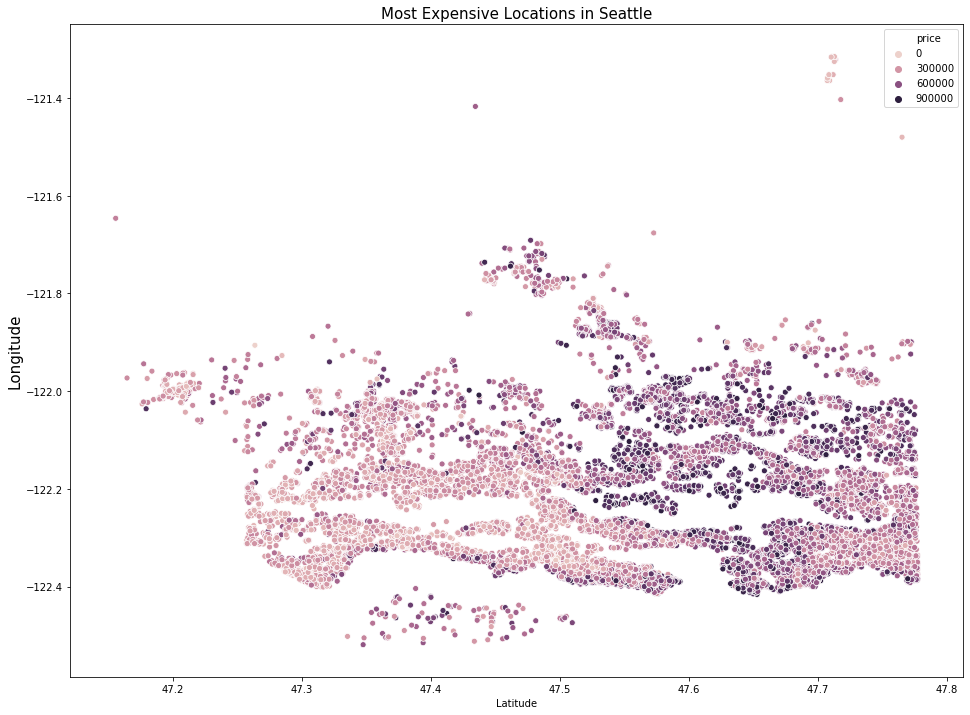

In [232]:
fig2, axes = plt.subplots( figsize = (16, 12))
ax = sns.scatterplot(x ='lat', y = 'long', hue = 'price', data = df[df.price< 900000])
ax.set_title('Most Expensive Locations in Seattle', size = 15)
ax.set_ylabel('Longitude', size = 15)
ax.set_xlabel('Latitude')
plt.savefig('lat_long_data_viz.png')

Text(0.5, 0, 'Best View Locations in Seattle')

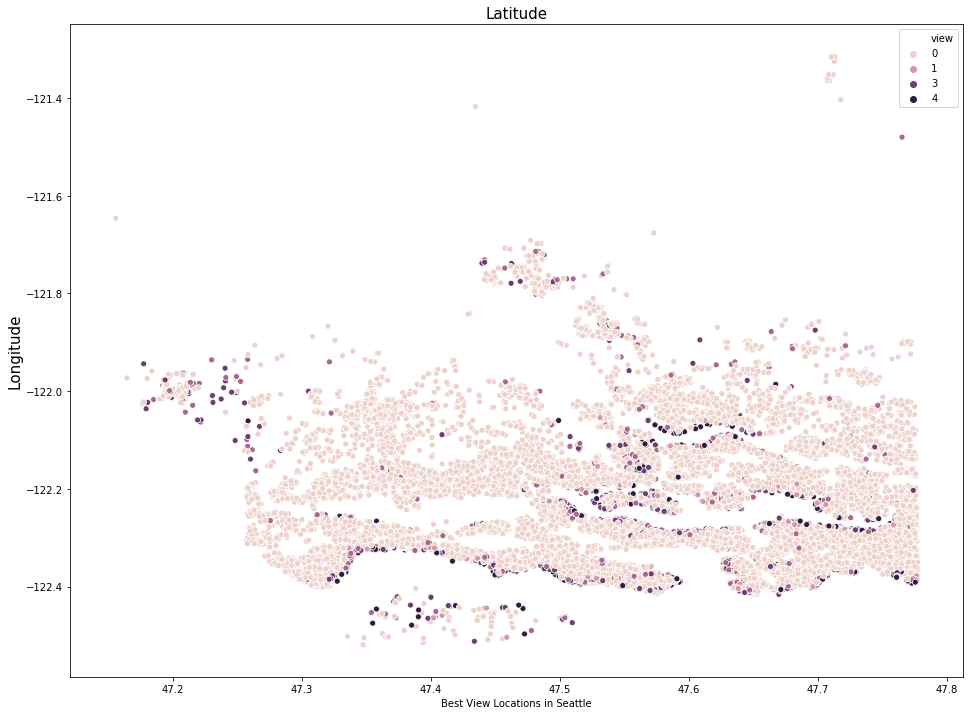

In [233]:
fig2, axes = plt.subplots( figsize = (16, 12))
ax = sns.scatterplot(x ='lat', y = 'long', hue = 'view', data = df)
ax.set_title('Latitude', size = 15)
ax.set_ylabel('Longitude', size = 15)
ax.set_xlabel('Best View Locations in Seattle')

These latitude- longitude scatter plots serve as visualization for expensive areas. Expensive areas do not seem to correlate directly with view, which makes sense as view is a much smaller selection of areas. In the one that has price as hue I limited it to below 900,000 so it would scale better for the variety of neighborhoods. This scale will not be part of my model however. 

The best way I can think to utilize is the good ol pythageron therom, however there are multiple "hot spots" for price so I will rank them, then create a new column for each on saying how far that house from it. 

In [234]:
lat_long = df.groupby(['lat', 'long'])['price'].mean().sort_values(ascending = False)[0:10].index

for x in range(0,len(lat_long)):
    df['ll'+str(x)] = ((df.lat - lat_long[x][0])**2 + (df.long - lat_long[x][1])**2) 
df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,ll0,ll1,ll2,ll3,ll4,ll5,ll6,ll7,ll8,ll9
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,...,0.062402,0.047309,0.042833,0.041179,0.037367,0.017754,0.058997,0.016275,0.110334,0.036373
1,1,7974200820,20140821T000000,865000.0,5,3.00,2900,6730,1.0,0,...,0.003806,0.005848,0.004319,0.005154,0.007272,0.018919,0.005479,0.020363,0.005052,0.007674
2,2,7701450110,20140815T000000,1038000.0,4,2.50,3770,10893,2.0,0,...,0.041887,0.014518,0.016664,0.014950,0.011715,0.006563,0.019290,0.006619,0.056915,0.011258
3,3,9522300010,20150331T000000,1490000.0,3,3.50,4560,14608,2.0,0,...,0.013883,0.002646,0.004905,0.005009,0.005886,0.018929,0.000809,0.020630,0.005184,0.006275
4,4,9510861140,20140714T000000,711000.0,3,2.50,2550,5376,2.0,0,...,0.058818,0.017377,0.025819,0.023782,0.020491,0.026452,0.016528,0.027728,0.045966,0.020423


In [235]:
from statsmodels.formula.api import ols

slr_model = ols(formula= """price~ll1+ll0+ll2+ll3+ll4+ll5+ll6+ll7+ll8+ll9""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     771.8
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        23:55:58   Log-Likelihood:            -2.4528e+05
No. Observations:               17290   AIC:                         4.906e+05
Df Residuals:                   17286   BIC:                         4.906e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.387e+05   3648.335    175.067      0.000    6.32e+05    6.46e+05
ll1        -1.058e+06   3.23e+04    -32.817      0.000   -1.12e+06   -9.95e+05
ll0         2.272e+06    9.1e+04     24.964      0.000    2.09e+06    2.45e+06
ll2        -1.208e+04   8167.189     -1.479      0.139   -2.81e+04    3926.208
ll3        -1.756e+05   9633.189    -18.231      0.000   -1.95e+05   -1.57e+05
ll4         -4.32e+05   1.97e+04    -21.883      0.000   -4.71e+05   -3.93e+05
ll5         3.361e+05   3.84e+04      8.747      0.000    2.61e+05    4.11e+05
ll6          -1.6e+06   4.65e+04    -34.404      0.000   -1.69e+06   -1.51e+06
ll7          4.42e+05   4.09e+04     10.818      0.000    3.62e+05    5.22e+05
ll8        -9.614e+05   4.99e+04    -19.284      0.000   -1.06e+06   -8.64e+05
ll9        -4.178e+05   2.05e+04    -20.356      0.000   -4.58e+05   -3.78e+05
==============================================================================
Omnibus:                    17149.649   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1572597.905
Skew:                           4.697   Prob(JB):                         0.00
Kurtosis:                      48.767   Cond. No.                     2.35e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.22e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

That was not as dramatic as I expected, lets add in zipcode and see if thats a better variable for location.

Text(0.5, 0, 'Average Price of Houses Sold')

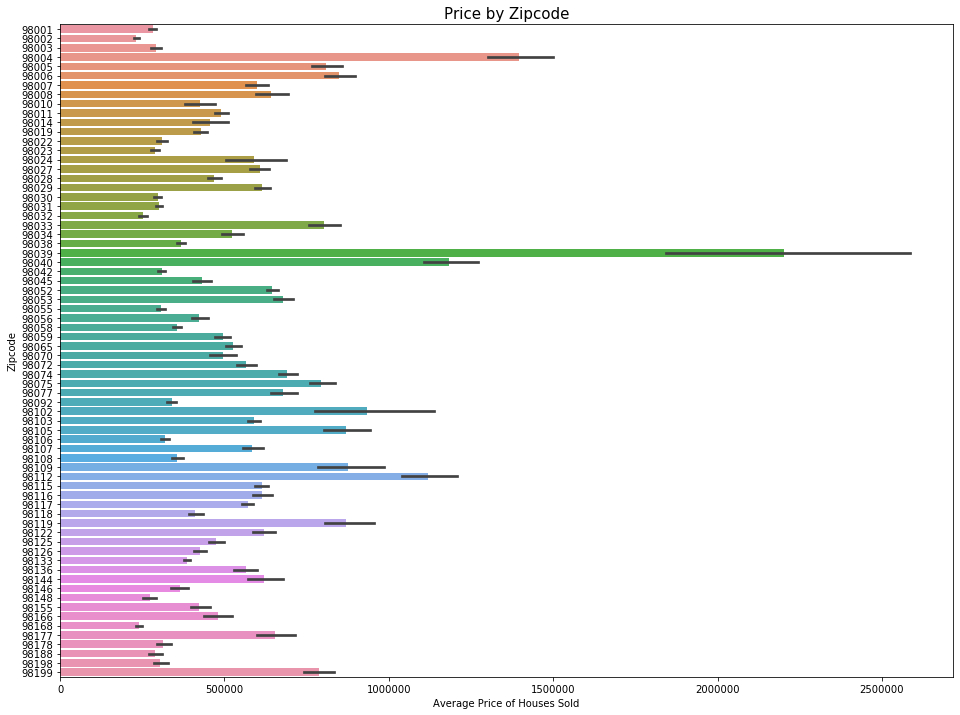

In [236]:

fig2, axes = plt.subplots( figsize = (16, 12))
ax = sns.barplot(df.price, df.zipcode, orient = 'h')
ax.set_title('Price by Zipcode', size = 15)
ax.set_ylabel('Zipcode', size = 10)
ax.set_xlabel('Average Price of Houses Sold')

This visualization is a deeper dive on location where the average prices of each zip houses sold in each zipcode. Price seems to vary drastically by zipcode. This is expected since zipcode is our proxy for urbanization, school districts etc... 98038 has the highest zipcode, 98002 seems to be the lowest. It will be interesting to see which zipcodes are significant in our model.

In [237]:
dummies = pd.get_dummies(df.zipcode)
data = pd.concat([df.price, dummies], axis = 1)

In [238]:
corr_mat = data.corr().sort_values('price', ascending = False)[0:10]['price']

In [239]:
corr_mat

price    1.000000
98004    0.270366
98039    0.219701
98040    0.199329
98112    0.174365
98006    0.124801
98033    0.101606
98075    0.087974
98105    0.087568
98119    0.082551
Name: price, dtype: float64

This Matrix shows the zipcodes which have the biggest positive correlation to price, surprisingly, different from the bar graph 98004 has a bigger correlation than 98039. 

In [240]:
corr_mat = data.corr().sort_values('price')[0:10]['price']

In [241]:
corr_mat

98023   -0.104858
98042   -0.098235
98168   -0.090086
98001   -0.089569
98002   -0.079096
98003   -0.076717
98038   -0.075885
98058   -0.075343
98106   -0.074458
98031   -0.072183
Name: price, dtype: float64

And the worst 

Now we will implement the dummy zipcode variables into our dataframe and make our first linear regression model!

In [242]:
df = pd.get_dummies(df, columns = ['zipcode'], drop_first = True)
zipcodes = []
for x in df.columns:
    if 'zipcode' in x:
        zipcodes.append(x)

In [243]:
zipcode_str = ' '.join(map(str, zipcodes))


In [244]:
from statsmodels.formula.api import ols

slr_model = ols(formula= """price~zipcode_98002+zipcode_98003+zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019+zipcode_98022 
                            +zipcode_98023+zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+zipcode_98030+zipcode_98031+zipcode_98032 
                            +zipcode_98033+zipcode_98034+zipcode_98038+zipcode_98039 
                            +zipcode_98040+zipcode_98042+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98055+zipcode_98056+zipcode_98058
                            +zipcode_98059+zipcode_98065+zipcode_98070+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105+zipcode_98106 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98148+zipcode_98155+zipcode_98166+zipcode_98168 
                            +zipcode_98177+zipcode_98178+zipcode_98188+zipcode_98198+zipcode_98199
                            +ll1+ll0+ll2+ll3+ll4+ll5+ll6+ll7+ll8+ll9""", data=df).fit()
slr_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     161.1
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        23:56:12   Log-Likelihood:            -2.4192e+05
No. Observations:               17290   AIC:                         4.840e+05
Df Residuals:                   17217   BIC:                         4.845e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.654e+05   4.69e+04      7.787      0.000    2.73e+05    4.57e+05
zipcode_98002 -6.927e+04   2.97e+04     -2.330      0.020   -1.28e+05    -1.1e+04
zipcode_98003  2.215e+04   2.64e+04      0.840      0.401   -2.95e+04    7.38e+04
zipcode_98004  1.015e+06   4.99e+04     20.340      0.000    9.17e+05    1.11e+06
zipcode_98005  4.167e+05   5.35e+04      7.784      0.000    3.12e+05    5.22e+05
zipcode_98006   4.56e+05   4.61e+04      9.899      0.000    3.66e+05    5.46e+05
zipcode_98007  1.999e+05   5.55e+04      3.600      0.000     9.1e+04    3.09e+05
zipcode_98008  2.386e+05   5.41e+04      4.412      0.000    1.33e+05    3.45e+05
zipcode_98010  8.434e+04   4.88e+04      1.729      0.084   -1.13e+04     1.8e+05
zipcode_98011  1.218e+05    6.5e+04      1.874      0.061   -5587.190    2.49e+05
zipcode_98014  1.027e+05   7.29e+04      1.408      0.159   -4.03e+04    2.46e+05
zipcode_98019  3.488e+04   7.31e+04      0.477      0.633   -1.08e+05    1.78e+05
zipcode_98022  3.511e+04   3.91e+04      0.899      0.369   -4.15e+04    1.12e+05
zipcode_98023   5.17e+04   2.64e+04      1.959      0.050     -20.525    1.03e+05
zipcode_98024  1.967e+05   6.77e+04      2.906      0.004     6.4e+04    3.29e+05
zipcode_98027  2.081e+05   4.94e+04      4.215      0.000    1.11e+05    3.05e+05
zipcode_98028  1.135e+05   6.28e+04      1.806      0.071   -9702.209    2.37e+05
zipcode_98029  2.098e+05   5.53e+04      3.793      0.000    1.01e+05    3.18e+05
zipcode_98030 -3.928e+04    3.1e+04     -1.265      0.206      -1e+05    2.16e+04
zipcode_98031 -4.869e+04   3.29e+04     -1.479      0.139   -1.13e+05    1.58e+04
zipcode_98032 -5.613e+04   3.44e+04     -1.631      0.103   -1.24e+05    1.13e+04
zipcode_98033  4.182e+05   5.57e+04      7.502      0.000    3.09e+05    5.27e+05
zipcode_98034  1.501e+05   5.86e+04      2.560      0.010    3.52e+04    2.65e+05
zipcode_98038  9835.7791   3.81e+04      0.258      0.796   -6.49e+04    8.45e+04
zipcode_98039  1.829e+06   6.41e+04     28.518      0.000     1.7e+06    1.95e+06
zipcode_98040  8.096e+05   4.39e+04     18.452      0.000    7.24e+05    8.96e+05
zipcode_98042 -4.027e+04   3.21e+04     -1.254      0.210   -1.03e+05    2.27e+04
zipcode_98045  9.661e+04   6.27e+04      1.542      0.123   -2.62e+04    2.19e+05
zipcode_98052  2.478e+05   5.82e+04      4.256      0.000    1.34e+05    3.62e+05
zipcode_98053  2.718e+05   6.34e+04      4.289      0.000    1.48e+05    3.96e+05
zipcode_98055 -5.515e+04   3.64e+04     -1.513      0.130   -1.27e+05    1.63e+04
zipcode_98056  4.465e+04      4e+04      1.115      0.265   -3.38e+04    1.23e+05
zipcode_98058 -1.768e+04   3.63e+04     -0.487      0.626   -8.88e+04    5.35e+04
zipcode_98059  1.095e+05   4.08e+04      2.682      0.007    2.95e+04     1.9e+05
zipcode_98065  1.458e+05   6.05e+04      2.410   

Location alone accounts for about .4% of the variance in housing prices! Not all of these have a p value of less than 0.05 so they can get taken out. I think there could be a better location variable then dummy zipcodes, especially just in terms of making the model less ugly. I'll keep doing what I can with these variable however then attempt to implement something better if I can.

# Mo Square Footage, Mo Money

This was another obvious feature I chose to implement in my model second. Lets take a look at a scatter plot of price vs. square footage to see what the relationship looks like. I chose to focus on sqft living since by reading the data description, that seemingly take into account the other variables pretty well. 

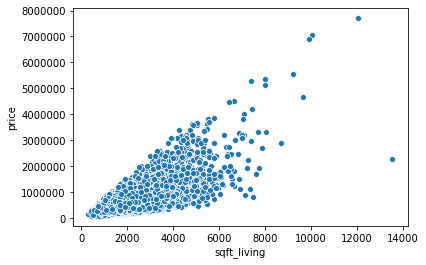

In [245]:
sns.scatterplot(x= 'sqft_living', y = 'price', data = df)

In [246]:
df['sqft_living'] = np.where((df.sqft_living > 12000)& (df.price < 30000000), 8000, df.sqft_living)

I can't imagine that outlier would help my model so I just made that datapoint's sqft lower manually, more in line with the overall trend. I assume it was a giant house in the middle of nowhere or something. Overall it looks like there is a strong correlation between square footage and price. The relationship could be exponential so I will expirement with that later. 

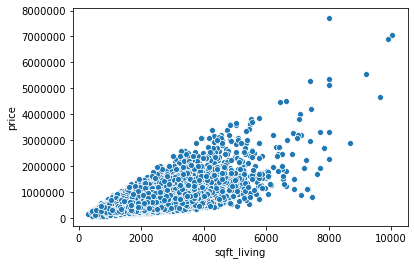

In [247]:
sns.scatterplot(x= 'sqft_living', y = 'price', data = df)

In [248]:
df['sqft_living'] = np.where((df.price > 6000000), 11000, df.sqft_living)
df['sqft_living'] = np.where((df.price < 1200000) & (df.sqft_living > 6500), 5500, df.sqft_living)

I took out some more outliers here, again this is adjust to adjust the trend for a better model and was determing by analyzing my residuals plot.

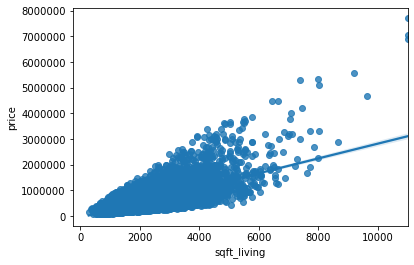

In [249]:
sns.regplot(x= 'sqft_living', y = 'price', data = df)

In [250]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98038+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98055+zipcode_98056+zipcode_98058
                            +zipcode_98059+zipcode_98065+zipcode_98070+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98148+zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sqft_living
                            +ll1+ll0+ll2+ll3+ll4+ll5+ll6+ll7+ll8+ll9""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     762.3
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        23:56:23   Log-Likelihood:            -2.3516e+05
No. Observations:               17290   AIC:                         4.704e+05
Df Residuals:                   17229   BIC:                         4.709e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -8.914e+04   1.11e+04     -8.017      0.000   -1.11e+05   -6.73e+04
zipcode_98004  7.307e+05   1.65e+04     44.164      0.000    6.98e+05    7.63e+05
zipcode_98005  2.213e+05   1.98e+04     11.196      0.000    1.83e+05     2.6e+05
zipcode_98006  2.342e+05   1.38e+04     17.001      0.000    2.07e+05    2.61e+05
zipcode_98007  1.635e+05   2.09e+04      7.823      0.000    1.23e+05    2.04e+05
zipcode_98008  1.965e+05   1.74e+04     11.262      0.000    1.62e+05    2.31e+05
zipcode_98010   6.56e+04   2.42e+04      2.716      0.007    1.82e+04    1.13e+05
zipcode_98011 -3.395e+04   2.25e+04     -1.506      0.132   -7.81e+04    1.02e+04
zipcode_98014  1794.3157   2.94e+04      0.061      0.951   -5.59e+04    5.95e+04
zipcode_98019 -7.469e+04   2.59e+04     -2.884      0.004   -1.25e+05   -2.39e+04
zipcode_98024  1.088e+05   2.86e+04      3.806      0.000    5.27e+04    1.65e+05
zipcode_98027  1.043e+05    1.5e+04      6.939      0.000    7.48e+04    1.34e+05
zipcode_98028 -3.036e+04    2.1e+04     -1.447      0.148   -7.15e+04    1.08e+04
zipcode_98029  1.462e+05   1.75e+04      8.357      0.000    1.12e+05     1.8e+05
zipcode_98033  2.645e+05   1.68e+04     15.767      0.000    2.32e+05    2.97e+05
zipcode_98034  7.962e+04   1.75e+04      4.562      0.000    4.54e+04    1.14e+05
zipcode_98038 -2339.2839    1.2e+04     -0.195      0.845   -2.58e+04    2.12e+04
zipcode_98039  1.291e+06   3.22e+04     40.101      0.000    1.23e+06    1.35e+06
zipcode_98040  5.079e+05   1.55e+04     32.846      0.000    4.78e+05    5.38e+05
zipcode_98045  6.756e+04   2.38e+04      2.839      0.005    2.09e+04    1.14e+05
zipcode_98052  1.152e+05   1.68e+04      6.868      0.000    8.23e+04    1.48e+05
zipcode_98053  8.919e+04   1.95e+04      4.585      0.000    5.11e+04    1.27e+05
zipcode_98055 -5136.6457   1.46e+04     -0.352      0.725   -3.37e+04    2.35e+04
zipcode_98056  3.638e+04   1.29e+04      2.821      0.005    1.11e+04    6.17e+04
zipcode_98058 -1.141e+04   1.18e+04     -0.963      0.335   -3.46e+04    1.18e+04
zipcode_98059  1.707e+04   1.27e+04      1.342      0.180   -7869.110     4.2e+04
zipcode_98065  7039.6298   2.01e+04      0.350      0.727   -3.24e+04    4.65e+04
zipcode_98070  1.592e+05   2.18e+04      7.299      0.000    1.16e+05    2.02e+05
zipcode_98072   1.62e+04   2.17e+04      0.747      0.455   -2.63e+04    5.87e+04
zipcode_98074  1.117e+05   1.71e+04      6.540      0.000    7.82e+04    1.45e+05
zipcode_98075  1.381e+05   1.74e+04      7.940      0.000    1.04e+05    1.72e+05
zipcode_98077   960.5860   2.38e+04      0.040      0.968   -4.58e+04    4.77e+04
zipcode_98092 -2.756e+04   1.25e+04     -2.198      0.028   -5.21e+04   -2979.745
zipcode_98102  4.477e+05   2.43e+04     18.407      0.000       4e+05    4.95e+05
zipcode_98103  2.367e+05   1.56e+04     15.170   

Hey thats not too shabby! Square footage jumped our R-squared by a whole .4, location and square footage alone unsurprisingly account for much of the variance in housing prices. If I was focusing on an interpretable model I would mainly hone in on these features. 

In [251]:
df['sq_sqft'] = df['sqft_living'] **2


In [252]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98038+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98055+zipcode_98056+zipcode_98058
                            +zipcode_98059+zipcode_98065+zipcode_98070+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98148+zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft
                            +ll1+ll0+ll2+ll3+ll4+ll5+ll6+ll7+ll8+ll9""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     975.1
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        23:56:24   Log-Likelihood:            -2.3357e+05
No. Observations:               17290   AIC:                         4.673e+05
Df Residuals:                   17229   BIC:                         4.677e+05
Df Model:                          60                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       1.76e+05   9864.648     17.844      0.000    1.57e+05    1.95e+05
zipcode_98004  7.308e+05   1.51e+04     48.514      0.000    7.01e+05     7.6e+05
zipcode_98005   2.68e+05    1.8e+04     14.899      0.000    2.33e+05    3.03e+05
zipcode_98006  2.521e+05   1.25e+04     20.120      0.000    2.28e+05    2.77e+05
zipcode_98007  2.079e+05    1.9e+04     10.916      0.000    1.71e+05    2.45e+05
zipcode_98008  2.344e+05   1.59e+04     14.745      0.000    2.03e+05    2.66e+05
zipcode_98010  6.641e+04    2.2e+04      3.015      0.003    2.32e+04     1.1e+05
zipcode_98011  3.745e+04   2.05e+04      1.825      0.068   -2774.900    7.77e+04
zipcode_98014    3.1e+04   2.68e+04      1.155      0.248   -2.16e+04    8.36e+04
zipcode_98019 -7726.2889   2.36e+04     -0.328      0.743    -5.4e+04    3.85e+04
zipcode_98024  1.161e+05   2.61e+04      4.456      0.000     6.5e+04    1.67e+05
zipcode_98027   1.27e+05   1.37e+04      9.278      0.000       1e+05    1.54e+05
zipcode_98028  3.745e+04   1.91e+04      1.960      0.050       3.537    7.49e+04
zipcode_98029  1.899e+05   1.59e+04     11.921      0.000    1.59e+05    2.21e+05
zipcode_98033  3.065e+05   1.53e+04     20.080      0.000    2.77e+05    3.36e+05
zipcode_98034  1.272e+05   1.59e+04      8.001      0.000     9.6e+04    1.58e+05
zipcode_98038   1.86e+04   1.09e+04      1.702      0.089   -2817.667       4e+04
zipcode_98039  1.145e+06   2.95e+04     38.865      0.000    1.09e+06     1.2e+06
zipcode_98040  5.183e+05   1.41e+04     36.846      0.000    4.91e+05    5.46e+05
zipcode_98045  8.762e+04   2.17e+04      4.038      0.000    4.51e+04     1.3e+05
zipcode_98052  1.794e+05   1.53e+04     11.758      0.000    1.49e+05    2.09e+05
zipcode_98053  1.298e+05   1.77e+04      7.331      0.000    9.51e+04    1.64e+05
zipcode_98055  1645.7999   1.33e+04      0.124      0.902   -2.44e+04    2.77e+04
zipcode_98056  5.501e+04   1.18e+04      4.680      0.000     3.2e+04     7.8e+04
zipcode_98058  5637.8401   1.08e+04      0.522      0.601   -1.55e+04    2.68e+04
zipcode_98059   4.51e+04   1.16e+04      3.894      0.000    2.24e+04    6.78e+04
zipcode_98065   5.11e+04   1.83e+04      2.788      0.005    1.52e+04     8.7e+04
zipcode_98070  1.752e+05   1.99e+04      8.809      0.000    1.36e+05    2.14e+05
zipcode_98072  8.019e+04   1.98e+04      4.060      0.000    4.15e+04    1.19e+05
zipcode_98074  1.624e+05   1.55e+04     10.455      0.000    1.32e+05    1.93e+05
zipcode_98075  1.904e+05   1.58e+04     12.048      0.000    1.59e+05    2.21e+05
zipcode_98077  5.159e+04   2.17e+04      2.378      0.017    9071.302    9.41e+04
zipcode_98092 -1.175e+04   1.14e+04     -1.028      0.304   -3.42e+04    1.07e+04
zipcode_98102  4.318e+05   2.22e+04     19.468      0.000    3.88e+05    4.75e+05
zipcode_98103  2.615e+05   1.42e+04     18.388   

Thats a pretty significant increase in R squared. So Im going to stick with square footage squared, say that five times fast.

# Interest Rate Analysis

I want to try and account for flucatating interest rates with some outside data. Ill just go month by month with a dataset I cleaned in another notebook. I need to make sure this merge goes smoothly enough to implement on the target data or its probably not worth the effort. 

In [253]:
df['year_month'] = df['date'].apply(lambda x: x[0:6])
df['year_month'] = df['year_month'].astype(str)

In [254]:
df = pd.merge(df,fedfunds, on = 'year_month', how = 'inner')
df = df.rename(columns = {'Effective Federal Funds Rate':'interest_rate'})

Nice, that wasn't too bad, lets chuck it in the model!

In [255]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98038+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98055+zipcode_98056+zipcode_98058
                            +zipcode_98059+zipcode_98065+zipcode_98070+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98148+zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft+interest_rate""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     1010.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        23:56:30   Log-Likelihood:            -2.3356e+05
No. Observations:               17290   AIC:                         4.672e+05
Df Residuals:                   17231   BIC:                         4.677e+05
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.466e+04   1.18e+04      2.097      0.036    1611.389    4.77e+04
zipcode_98004  7.847e+05   1.22e+04     64.583      0.000    7.61e+05    8.09e+05
zipcode_98005  3.217e+05   1.54e+04     20.838      0.000    2.91e+05    3.52e+05
zipcode_98006   2.94e+05   9742.927     30.173      0.000    2.75e+05    3.13e+05
zipcode_98007  2.611e+05   1.64e+04     15.873      0.000    2.29e+05    2.93e+05
zipcode_98008  2.861e+05   1.23e+04     23.311      0.000    2.62e+05     3.1e+05
zipcode_98010  5.178e+04    2.1e+04      2.469      0.014    1.07e+04    9.29e+04
zipcode_98011  1.184e+05   1.43e+04      8.270      0.000    9.04e+04    1.47e+05
zipcode_98014  7.871e+04    1.8e+04      4.367      0.000    4.34e+04    1.14e+05
zipcode_98019  6.062e+04   1.51e+04      4.003      0.000    3.09e+04    9.03e+04
zipcode_98024  1.465e+05   2.24e+04      6.553      0.000    1.03e+05     1.9e+05
zipcode_98027  1.575e+05   1.03e+04     15.257      0.000    1.37e+05    1.78e+05
zipcode_98028  1.189e+05   1.25e+04      9.546      0.000    9.45e+04    1.43e+05
zipcode_98029  2.275e+05   1.17e+04     19.409      0.000    2.05e+05     2.5e+05
zipcode_98033  3.739e+05      1e+04     37.375      0.000    3.54e+05    3.94e+05
zipcode_98034  2.019e+05   9108.454     22.165      0.000    1.84e+05     2.2e+05
zipcode_98038  1.318e+04   8936.295      1.475      0.140   -4332.842    3.07e+04
zipcode_98039  1.205e+06    2.8e+04     43.017      0.000    1.15e+06    1.26e+06
zipcode_98040  5.615e+05   1.24e+04     45.463      0.000    5.37e+05    5.86e+05
zipcode_98045  9.055e+04   1.38e+04      6.558      0.000    6.35e+04    1.18e+05
zipcode_98052  2.457e+05   8796.479     27.927      0.000    2.28e+05    2.63e+05
zipcode_98053  1.927e+05   1.05e+04     18.427      0.000    1.72e+05    2.13e+05
zipcode_98055  2.147e+04   1.27e+04      1.691      0.091   -3415.581    4.64e+04
zipcode_98056  8.583e+04   1.02e+04      8.395      0.000    6.58e+04    1.06e+05
zipcode_98058  2.145e+04   9616.567      2.230      0.026    2595.803    4.03e+04
zipcode_98059  7.188e+04   9782.048      7.349      0.000    5.27e+04    9.11e+04
zipcode_98065  7.346e+04   1.18e+04      6.243      0.000    5.04e+04    9.65e+04
zipcode_98070  1.866e+05   1.82e+04     10.256      0.000    1.51e+05    2.22e+05
zipcode_98072  1.583e+05   1.26e+04     12.587      0.000    1.34e+05    1.83e+05
zipcode_98074  2.148e+05   9994.718     21.492      0.000    1.95e+05    2.34e+05
zipcode_98075  2.338e+05   1.11e+04     21.036      0.000    2.12e+05    2.56e+05
zipcode_98077  1.282e+05   1.44e+04      8.879      0.000    9.99e+04    1.57e+05
zipcode_98092  -3.09e+04    1.1e+04     -2.807      0.005   -5.25e+04   -9319.711
zipcode_98102  4.922e+05   2.02e+04     24.363      0.000    4.53e+05    5.32e+05
zipcode_98103  3.284e+05   8879.376     36.988   

Well that was alot of work for an undewhelming improvement. It's still a significant variable though so I will leave it in. Also just realized that this data is only from 2014-2015 oops, interest rates probably dont fluctaute too much in that short of a time span. Atleast I learned a little about merging dataframes

# Old Houses Have Character

Lets take a look at the year built and year renovated and try and engineer them into something more useable. 

In [256]:
df['yrs_old'] = 2020 - df.yr_built

In [257]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98056
                            +zipcode_98059+zipcode_98065+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft+interest_rate+yrs_old""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     1078.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        23:56:34   Log-Likelihood:            -2.3360e+05
No. Observations:               17290   AIC:                         4.673e+05
Df Residuals:                   17235   BIC:                         4.677e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.087e+04    1.2e+04      1.739      0.082   -2646.850    4.44e+04
zipcode_98004  7.728e+05   1.21e+04     64.006      0.000    7.49e+05    7.96e+05
zipcode_98005    3.1e+05   1.54e+04     20.140      0.000     2.8e+05     3.4e+05
zipcode_98006  2.845e+05   9619.221     29.572      0.000    2.66e+05    3.03e+05
zipcode_98007  2.508e+05   1.64e+04     15.282      0.000    2.19e+05    2.83e+05
zipcode_98008  2.745e+05   1.22e+04     22.492      0.000    2.51e+05    2.98e+05
zipcode_98010  4.393e+04    2.1e+04      2.096      0.036    2857.519     8.5e+04
zipcode_98011  1.109e+05   1.43e+04      7.775      0.000    8.29e+04    1.39e+05
zipcode_98014   7.08e+04    1.8e+04      3.935      0.000    3.55e+04    1.06e+05
zipcode_98019  5.599e+04   1.51e+04      3.705      0.000    2.64e+04    8.56e+04
zipcode_98024  1.357e+05   2.23e+04      6.071      0.000    9.19e+04    1.79e+05
zipcode_98027  1.509e+05   1.02e+04     14.765      0.000    1.31e+05    1.71e+05
zipcode_98028  1.105e+05   1.24e+04      8.930      0.000    8.63e+04    1.35e+05
zipcode_98029  2.243e+05   1.17e+04     19.196      0.000    2.01e+05    2.47e+05
zipcode_98033  3.653e+05   9889.160     36.937      0.000    3.46e+05    3.85e+05
zipcode_98034  1.932e+05   8981.555     21.514      0.000    1.76e+05    2.11e+05
zipcode_98039  1.192e+06    2.8e+04     42.501      0.000    1.14e+06    1.25e+06
zipcode_98040  5.494e+05   1.23e+04     44.739      0.000    5.25e+05    5.73e+05
zipcode_98045  8.399e+04   1.37e+04      6.110      0.000     5.7e+04    1.11e+05
zipcode_98052  2.389e+05   8669.910     27.560      0.000    2.22e+05    2.56e+05
zipcode_98053  1.889e+05   1.04e+04     18.172      0.000    1.69e+05    2.09e+05
zipcode_98056  7.737e+04   1.01e+04      7.648      0.000    5.75e+04    9.72e+04
zipcode_98059  6.595e+04   9679.874      6.813      0.000     4.7e+04    8.49e+04
zipcode_98065  6.941e+04   1.17e+04      5.926      0.000    4.65e+04    9.24e+04
zipcode_98072  1.506e+05   1.25e+04     12.045      0.000    1.26e+05    1.75e+05
zipcode_98074  2.089e+05   9894.193     21.110      0.000    1.89e+05    2.28e+05
zipcode_98075  2.283e+05    1.1e+04     20.694      0.000    2.07e+05     2.5e+05
zipcode_98077  1.201e+05   1.44e+04      8.356      0.000    9.19e+04    1.48e+05
zipcode_98092 -3.605e+04   1.09e+04     -3.296      0.001   -5.75e+04   -1.46e+04
zipcode_98102   4.75e+05   2.02e+04     23.455      0.000    4.35e+05    5.15e+05
zipcode_98103  3.134e+05   8840.615     35.448      0.000    2.96e+05    3.31e+05
zipcode_98105  4.734e+05   1.41e+04     33.549      0.000    4.46e+05    5.01e+05
zipcode_98107   3.18e+05   1.26e+04     25.260      0.000    2.93e+05    3.43e+05
zipcode_98108  7.592e+04   1.48e+04      5.122      0.000    4.69e+04    1.05e+05
zipcode_98109  5.013e+05   1.97e+04     25.499   

Years old seems to slightly reduce r squared even though it is significant. I think I'm going to keep it out of the model, since old houses can be considered desirable. 

Earlier I notice almost all the houses had not been renovated, lets just makes this a dummy variable

In [258]:
df['has_been_renovated'] = df['yr_renovated'].apply(lambda x: x>0).astype(int)

In [259]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98056
                            +zipcode_98059+zipcode_98065+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft+interest_rate+has_been_renovated""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     1086.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        23:56:37   Log-Likelihood:            -2.3355e+05
No. Observations:               17290   AIC:                         4.672e+05
Df Residuals:                   17235   BIC:                         4.676e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           3.004e+04   1.16e+04      2.580      0.010    7220.810    5.29e+04
zipcode_98004       7.713e+05    1.2e+04     64.117      0.000    7.48e+05    7.95e+05
zipcode_98005       3.136e+05   1.53e+04     20.449      0.000    2.84e+05    3.44e+05
zipcode_98006       2.853e+05   9589.592     29.749      0.000    2.66e+05    3.04e+05
zipcode_98007       2.535e+05   1.64e+04     15.500      0.000    2.21e+05    2.86e+05
zipcode_98008       2.778e+05   1.22e+04     22.853      0.000    2.54e+05    3.02e+05
zipcode_98010       3.928e+04   2.09e+04      1.880      0.060   -1673.477    8.02e+04
zipcode_98011       1.098e+05   1.42e+04      7.725      0.000     8.2e+04    1.38e+05
zipcode_98014       7.022e+04   1.79e+04      3.914      0.000    3.51e+04    1.05e+05
zipcode_98019       5.116e+04    1.5e+04      3.401      0.001    2.17e+04    8.06e+04
zipcode_98024       1.321e+05   2.23e+04      5.928      0.000    8.84e+04    1.76e+05
zipcode_98027       1.501e+05   1.02e+04     14.743      0.000     1.3e+05     1.7e+05
zipcode_98028       1.112e+05   1.23e+04      9.012      0.000     8.7e+04    1.35e+05
zipcode_98029       2.213e+05   1.16e+04     19.084      0.000    1.99e+05    2.44e+05
zipcode_98033       3.639e+05   9859.977     36.910      0.000    3.45e+05    3.83e+05
zipcode_98034       1.946e+05   8955.529     21.734      0.000    1.77e+05    2.12e+05
zipcode_98039        1.19e+06   2.79e+04     42.574      0.000    1.13e+06    1.24e+06
zipcode_98040       5.469e+05   1.22e+04     44.695      0.000    5.23e+05    5.71e+05
zipcode_98045       8.205e+04   1.37e+04      5.990      0.000    5.52e+04    1.09e+05
zipcode_98052       2.386e+05   8635.465     27.626      0.000    2.22e+05    2.55e+05
zipcode_98053       1.864e+05   1.03e+04     18.061      0.000    1.66e+05    2.07e+05
zipcode_98056       7.811e+04   1.01e+04      7.745      0.000    5.83e+04    9.79e+04
zipcode_98059       6.415e+04   9634.821      6.658      0.000    4.53e+04     8.3e+04
zipcode_98065       6.561e+04   1.16e+04      5.636      0.000    4.28e+04    8.84e+04
zipcode_98072         1.5e+05   1.25e+04     12.040      0.000    1.26e+05    1.74e+05
zipcode_98074       2.076e+05   9848.941     21.080      0.000    1.88e+05    2.27e+05
zipcode_98075       2.271e+05    1.1e+04     20.679      0.000    2.06e+05    2.49e+05
zipcode_98077       1.211e+05   1.43e+04      8.449      0.000     9.3e+04    1.49e+05
zipcode_98092      -3.823e+04   1.09e+04     -3.514      0.000   -5.96e+04   -1.69e+04
zipcode_98102       4.823e+05   2.01e+04     23.972      0.000    4.43e+05    5.22e+05
zipcode_98103        3.17e+05   8727.519     36.322      0.000       3e+05    3.34e+05
zipcode_98105       4.822e+05   1.39e+04     34.602      0.000    4.55e+05    5.09e+05
zipcode_98107       3.209e+05   1.25e+

Another significant one based on p values that does little to affect R squared

Let me try one more thing 

In [260]:
df['ren_in_lastyr'] = np.where(df['yr_renovated'] >=2014, 1, 0)

In [261]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98056
                            +zipcode_98059+zipcode_98065+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft+interest_rate+ren_in_lastyr""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     1076.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        23:56:39   Log-Likelihood:            -2.3361e+05
No. Observations:               17290   AIC:                         4.673e+05
Df Residuals:                   17235   BIC:                         4.678e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      3.457e+04   1.17e+04      2.960      0.003    1.17e+04    5.75e+04
zipcode_98004  7.759e+05   1.21e+04     64.301      0.000    7.52e+05       8e+05
zipcode_98005  3.127e+05   1.54e+04     20.315      0.000    2.83e+05    3.43e+05
zipcode_98006  2.847e+05   9626.309     29.576      0.000    2.66e+05    3.04e+05
zipcode_98007  2.525e+05   1.64e+04     15.380      0.000     2.2e+05    2.85e+05
zipcode_98008  2.772e+05   1.22e+04     22.717      0.000    2.53e+05    3.01e+05
zipcode_98010  4.313e+04    2.1e+04      2.057      0.040    2029.221    8.42e+04
zipcode_98011  1.098e+05   1.43e+04      7.695      0.000    8.18e+04    1.38e+05
zipcode_98014  7.008e+04    1.8e+04      3.892      0.000    3.48e+04    1.05e+05
zipcode_98019  5.174e+04   1.51e+04      3.427      0.001    2.21e+04    8.13e+04
zipcode_98024  1.378e+05   2.24e+04      6.164      0.000     9.4e+04    1.82e+05
zipcode_98027  1.488e+05   1.02e+04     14.562      0.000    1.29e+05    1.69e+05
zipcode_98028  1.103e+05   1.24e+04      8.906      0.000     8.6e+04    1.35e+05
zipcode_98029  2.188e+05   1.16e+04     18.802      0.000    1.96e+05    2.42e+05
zipcode_98033  3.651e+05   9895.302     36.899      0.000    3.46e+05    3.85e+05
zipcode_98034  1.933e+05   8987.394     21.507      0.000    1.76e+05    2.11e+05
zipcode_98039  1.196e+06    2.8e+04     42.653      0.000    1.14e+06    1.25e+06
zipcode_98040  5.527e+05   1.23e+04     45.047      0.000    5.29e+05    5.77e+05
zipcode_98045  8.192e+04   1.37e+04      5.958      0.000     5.5e+04    1.09e+05
zipcode_98052  2.368e+05   8665.594     27.330      0.000     2.2e+05    2.54e+05
zipcode_98053   1.84e+05   1.04e+04     17.769      0.000    1.64e+05    2.04e+05
zipcode_98056  7.723e+04   1.01e+04      7.630      0.000    5.74e+04    9.71e+04
zipcode_98059  6.312e+04   9669.427      6.528      0.000    4.42e+04    8.21e+04
zipcode_98065  6.478e+04   1.17e+04      5.545      0.000    4.19e+04    8.77e+04
zipcode_98072  1.497e+05   1.25e+04     11.969      0.000    1.25e+05    1.74e+05
zipcode_98074   2.06e+05   9883.706     20.842      0.000    1.87e+05    2.25e+05
zipcode_98075  2.251e+05    1.1e+04     20.425      0.000    2.03e+05    2.47e+05
zipcode_98077  1.194e+05   1.44e+04      8.305      0.000    9.13e+04    1.48e+05
zipcode_98092 -3.965e+04   1.09e+04     -3.631      0.000    -6.1e+04   -1.82e+04
zipcode_98102   4.83e+05   2.02e+04     23.918      0.000    4.43e+05    5.23e+05
zipcode_98103  3.196e+05   8756.169     36.502      0.000    3.02e+05    3.37e+05
zipcode_98105  4.834e+05    1.4e+04     34.563      0.000    4.56e+05    5.11e+05
zipcode_98107  3.217e+05   1.26e+04     25.582      0.000    2.97e+05    3.46e+05
zipcode_98108  8.038e+04   1.48e+04      5.430      0.000    5.14e+04    1.09e+05
zipcode_98109  5.102e+05   1.96e+04     26.047   

Not any better really, Ill probably keep this out, not sure what to do with renovated

# Even Houses Get Graded

I'm going to turn the different grades into dummies since they are categorical, not sure how much it matters but it will also be interesting to see if a low grade has a big negative coefficient or if a high grade has a higher positive coefficient. 

In [262]:
df = pd.get_dummies(df, columns = ['grade'], drop_first = True)

In [263]:
df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,...,0,0,0,0,1,0,0,0,0,0
1,7,7010701383,20141017T000000,680000.0,3,2.50,1800,4400,1.0,0,...,0,0,0,1,0,0,0,0,0,0
2,17,2386000070,20141029T000000,795127.0,4,3.25,4360,91158,1.0,0,...,0,0,0,0,0,0,1,0,0,0
3,18,1138000450,20141016T000000,355000.0,4,1.00,1440,7215,1.5,0,...,0,0,0,1,0,0,0,0,0,0
4,23,9324800450,20141009T000000,560000.0,3,1.50,2790,6900,1.0,0,...,0,0,0,0,1,0,0,0,0,0


In [264]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98056
                            +zipcode_98059+zipcode_98065+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft+ interest_rate
                            +grade_3+grade_4+grade_5+grade_6+grade_7+grade_8+grade_9
                            +grade_10+grade_11+grade_12+has_been_renovated
                            +interest_rate+ren_in_lastyr""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     1053.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        23:56:42   Log-Likelihood:            -2.3250e+05
No. Observations:               17290   AIC:                         4.651e+05
Df Residuals:                   17224   BIC:                         4.656e+05
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.181e+06   5.45e+04     21.654      0.000    1.07e+06    1.29e+06
zipcode_98004       7.275e+05   1.14e+04     63.949      0.000    7.05e+05     7.5e+05
zipcode_98005       2.747e+05   1.45e+04     18.963      0.000    2.46e+05    3.03e+05
zipcode_98006       2.363e+05   9115.042     25.919      0.000    2.18e+05    2.54e+05
zipcode_98007       2.274e+05   1.54e+04     14.744      0.000    1.97e+05    2.58e+05
zipcode_98008       2.764e+05   1.15e+04     24.127      0.000    2.54e+05    2.99e+05
zipcode_98010       3.379e+04   1.97e+04      1.717      0.086   -4785.130    7.24e+04
zipcode_98011       1.035e+05   1.34e+04      7.727      0.000    7.73e+04     1.3e+05
zipcode_98014       6.879e+04   1.69e+04      4.067      0.000    3.56e+04    1.02e+05
zipcode_98019       5.706e+04   1.42e+04      4.027      0.000    2.93e+04    8.48e+04
zipcode_98024       1.189e+05    2.1e+04      5.664      0.000    7.78e+04     1.6e+05
zipcode_98027       1.281e+05   9621.333     13.310      0.000    1.09e+05    1.47e+05
zipcode_98028       1.112e+05   1.16e+04      9.562      0.000    8.84e+04    1.34e+05
zipcode_98029       1.769e+05    1.1e+04     16.014      0.000    1.55e+05    1.99e+05
zipcode_98033       3.369e+05   9318.152     36.157      0.000    3.19e+05    3.55e+05
zipcode_98034       1.853e+05   8455.793     21.914      0.000    1.69e+05    2.02e+05
zipcode_98039       1.123e+06   2.64e+04     42.562      0.000    1.07e+06    1.18e+06
zipcode_98040       4.965e+05   1.16e+04     42.763      0.000    4.74e+05    5.19e+05
zipcode_98045       7.035e+04   1.29e+04      5.452      0.000    4.51e+04    9.56e+04
zipcode_98052       2.114e+05   8210.339     25.748      0.000    1.95e+05    2.27e+05
zipcode_98053       1.672e+05   9748.943     17.148      0.000    1.48e+05    1.86e+05
zipcode_98056       7.724e+04   9523.297      8.111      0.000    5.86e+04    9.59e+04
zipcode_98059       5.179e+04   9095.915      5.694      0.000     3.4e+04    6.96e+04
zipcode_98065       6.822e+04    1.1e+04      6.216      0.000    4.67e+04    8.97e+04
zipcode_98072       1.285e+05   1.18e+04     10.929      0.000    1.05e+05    1.52e+05
zipcode_98074       1.532e+05   9419.247     16.266      0.000    1.35e+05    1.72e+05
zipcode_98075       1.675e+05   1.05e+04     15.921      0.000    1.47e+05    1.88e+05
zipcode_98077       7.097e+04   1.36e+04      5.234      0.000    4.44e+04    9.75e+04
zipcode_98092      -5.244e+04   1.03e+04     -5.104      0.000   -7.26e+04   -3.23e+04
zipcode_98102        4.39e+05    1.9e+04     23.097      0.000    4.02e+05    4.76e+05
zipcode_98103       3.048e+05   8232.334     37.019      0.000    2.89e+05    3.21e+05
zipcode_98105       4.652e+05   1.31e+04     35.428      0.000    4.39e+05    4.91e+05
zipcode_98107       3.038e+05   1.18e+

Pretty huge increase at this point in the game. No idea why grade has a negative coefficient, seams very counter intuitive, having a high grade has the lowest, must be something with dummy variables I dont understand. Lets chuck waterfront in there since thats already useable as is in the graph 

In [265]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98056
                            +zipcode_98059+zipcode_98065+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft+
                            grade_3+grade_4+grade_5+grade_6+grade_7
                            +grade_8+grade_9+grade_10+grade_11+grade_12
                            +waterfront+interest_rate+ren_in_lastyr""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     1296.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        23:56:44   Log-Likelihood:            -2.3103e+05
No. Observations:               17290   AIC:                         4.622e+05
Df Residuals:                   17224   BIC:                         4.627e+05
Df Model:                          65                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.253e+06   5.01e+04     25.000      0.000    1.15e+06    1.35e+06
zipcode_98004  7.525e+05   1.04e+04     72.032      0.000    7.32e+05    7.73e+05
zipcode_98005  2.902e+05   1.33e+04     21.800      0.000    2.64e+05    3.16e+05
zipcode_98006   2.51e+05   8378.285     29.957      0.000    2.35e+05    2.67e+05
zipcode_98007  2.348e+05   1.42e+04     16.567      0.000    2.07e+05    2.63e+05
zipcode_98008  2.593e+05   1.05e+04     24.626      0.000    2.39e+05     2.8e+05
zipcode_98010  4.898e+04   1.81e+04      2.709      0.007    1.35e+04    8.44e+04
zipcode_98011  1.126e+05   1.23e+04      9.143      0.000    8.84e+04    1.37e+05
zipcode_98014  7.957e+04   1.55e+04      5.120      0.000    4.91e+04     1.1e+05
zipcode_98019   6.62e+04    1.3e+04      5.085      0.000    4.07e+04    9.17e+04
zipcode_98024  1.371e+05   1.93e+04      7.108      0.000    9.93e+04    1.75e+05
zipcode_98027  1.385e+05   8841.381     15.664      0.000    1.21e+05    1.56e+05
zipcode_98028  1.147e+05   1.07e+04     10.733      0.000    9.37e+04    1.36e+05
zipcode_98029  1.854e+05   1.02e+04     18.262      0.000    1.65e+05    2.05e+05
zipcode_98033   3.42e+05   8560.278     39.947      0.000    3.25e+05    3.59e+05
zipcode_98034  1.825e+05   7768.266     23.496      0.000    1.67e+05    1.98e+05
zipcode_98039  1.151e+06   2.42e+04     47.488      0.000     1.1e+06     1.2e+06
zipcode_98040  4.927e+05   1.07e+04     46.238      0.000    4.72e+05    5.14e+05
zipcode_98045  7.937e+04   1.19e+04      6.695      0.000    5.61e+04    1.03e+05
zipcode_98052  2.171e+05   7543.272     28.777      0.000    2.02e+05    2.32e+05
zipcode_98053  1.793e+05   8958.746     20.017      0.000    1.62e+05    1.97e+05
zipcode_98056  7.807e+04   8749.234      8.923      0.000    6.09e+04    9.52e+04
zipcode_98059  6.288e+04   8359.059      7.522      0.000    4.65e+04    7.93e+04
zipcode_98065   7.99e+04   1.01e+04      7.923      0.000    6.01e+04    9.97e+04
zipcode_98072  1.398e+05   1.08e+04     12.944      0.000    1.19e+05    1.61e+05
zipcode_98074   1.56e+05   8653.697     18.029      0.000    1.39e+05    1.73e+05
zipcode_98075  1.574e+05   9667.528     16.276      0.000    1.38e+05    1.76e+05
zipcode_98077  8.884e+04   1.25e+04      7.129      0.000    6.44e+04    1.13e+05
zipcode_98092 -4.477e+04   9440.357     -4.742      0.000   -6.33e+04   -2.63e+04
zipcode_98102  4.498e+05   1.75e+04     25.758      0.000    4.16e+05    4.84e+05
zipcode_98103  3.133e+05   7560.798     41.432      0.000    2.98e+05    3.28e+05
zipcode_98105  4.678e+05   1.21e+04     38.776      0.000    4.44e+05    4.91e+05
zipcode_98107    3.1e+05   1.09e+04     28.556      0.000    2.89e+05    3.31e+05
zipcode_98108  8.918e+04   1.28e+04      6.990      0.000    6.42e+04    1.14e+05
zipcode_98109  4.905e+05   1.69e+04     29.020   

Wooooo! We broke the .8 R-squared barrier, this is the greatest model ever made. Did not expect water front to matter so much since there are only 100ish data points that have it, but apparently its a big deal, especially when we are hunting down minute improvements. 

# Time of Year Analysis

Lets take a look at time of year, no one likes moving in the winter. Im just going to make season columns first. 

In [266]:
df['month'] = df['date'].apply(lambda x: x[4:6])

In [267]:
df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade_5,grade_6,grade_7,grade_8,grade_9,grade_10,grade_11,grade_12,grade_13,month
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,...,0,0,0,1,0,0,0,0,0,10
1,7,7010701383,20141017T000000,680000.0,3,2.50,1800,4400,1.0,0,...,0,0,1,0,0,0,0,0,0,10
2,17,2386000070,20141029T000000,795127.0,4,3.25,4360,91158,1.0,0,...,0,0,0,0,0,1,0,0,0,10
3,18,1138000450,20141016T000000,355000.0,4,1.00,1440,7215,1.5,0,...,0,0,1,0,0,0,0,0,0,10
4,23,9324800450,20141009T000000,560000.0,3,1.50,2790,6900,1.0,0,...,0,0,0,1,0,0,0,0,0,10


In [268]:
df['month'] = df['month'].astype(int)
df['fall'] = df['month'].apply(lambda x: x>9).astype(int)
df['winter'] = df['month'].apply(lambda x: x<3).astype(int)
df['spring'] = df['month'].apply(lambda x: 6>x>3).astype(int)
df['summer'] = df['month'].apply(lambda x: 9>x>6).astype(int)
df.head(20)

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade_9,grade_10,grade_11,grade_12,grade_13,month,fall,winter,spring,summer
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,...,0,0,0,0,0,10,1,0,0,0
1,7,7010701383,20141017T000000,680000.0,3,2.50,1800,4400,1.0,0,...,0,0,0,0,0,10,1,0,0,0
2,17,2386000070,20141029T000000,795127.0,4,3.25,4360,91158,1.0,0,...,0,1,0,0,0,10,1,0,0,0
3,18,1138000450,20141016T000000,355000.0,4,1.00,1440,7215,1.5,0,...,0,0,0,0,0,10,1,0,0,0
4,23,9324800450,20141009T000000,560000.0,3,1.50,2790,6900,1.0,0,...,0,0,0,0,0,10,1,0,0,0
5,33,16000200,20141024T000000,250000.0,3,2.25,1640,4420,2.0,0,...,0,0,0,0,0,10,1,0,0,0
6,53,2770601800,20141024T000000,525000.0,3,1.75,1560,6000,1.0,0,...,0,0,0,0,0,10,1,0,0,0
7,59,3224600340,20141013T000000,695000.0,4,2.50,2790,6540,2.0,0,...,1,0,0,0,0,10,1,0,0,0
8,62,7893207925,20141022T000000,265000.0,3,1.50,1290,7100,1.0,0,...,0,0,0,0,0,10,1,0,0,0
9,64,8024200010,20141028T000000,312000.0,2,1.00,1460,6000,1.0,0,...,0,0,0,0,0,10,1,0,0,0


In [269]:
slr_model = ols(formula= """price~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98056
                            +zipcode_98059+zipcode_98065+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft+interest_rate
                            +grade_3
                            +grade_4+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11
                            +grade_12+waterfront+interest_rate+ren_in_lastyr+spring+summer+fall+winter""", data=df).fit()
slr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     1224.
Date:                Thu, 22 Oct 2020   Prob (F-statistic):               0.00
Time:                        23:56:48   Log-Likelihood:            -2.3101e+05
No. Observations:               17290   AIC:                         4.622e+05
Df Residuals:                   17220   BIC:                         4.627e+05
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.249e+06   5.05e+04     24.738      0.000    1.15e+06    1.35e+06
zipcode_98004  7.525e+05   1.04e+04     72.102      0.000    7.32e+05    7.73e+05
zipcode_98005  2.906e+05   1.33e+04     21.853      0.000    2.65e+05    3.17e+05
zipcode_98006  2.508e+05   8369.890     29.970      0.000    2.34e+05    2.67e+05
zipcode_98007  2.333e+05   1.42e+04     16.473      0.000    2.06e+05    2.61e+05
zipcode_98008  2.593e+05   1.05e+04     24.658      0.000    2.39e+05     2.8e+05
zipcode_98010  4.882e+04   1.81e+04      2.702      0.007    1.34e+04    8.42e+04
zipcode_98011  1.132e+05   1.23e+04      9.201      0.000    8.91e+04    1.37e+05
zipcode_98014   7.89e+04   1.55e+04      5.081      0.000    4.85e+04    1.09e+05
zipcode_98019  6.539e+04    1.3e+04      5.028      0.000    3.99e+04    9.09e+04
zipcode_98024  1.365e+05   1.93e+04      7.087      0.000    9.88e+04    1.74e+05
zipcode_98027  1.375e+05   8834.330     15.564      0.000     1.2e+05    1.55e+05
zipcode_98028  1.136e+05   1.07e+04     10.643      0.000    9.27e+04    1.35e+05
zipcode_98029  1.845e+05   1.01e+04     18.195      0.000    1.65e+05    2.04e+05
zipcode_98033  3.415e+05   8553.370     39.923      0.000    3.25e+05    3.58e+05
zipcode_98034  1.826e+05   7760.732     23.533      0.000    1.67e+05    1.98e+05
zipcode_98039  1.151e+06   2.42e+04     47.531      0.000     1.1e+06     1.2e+06
zipcode_98040  4.911e+05   1.06e+04     46.119      0.000     4.7e+05    5.12e+05
zipcode_98045  7.862e+04   1.18e+04      6.638      0.000    5.54e+04    1.02e+05
zipcode_98052  2.162e+05   7536.985     28.679      0.000    2.01e+05    2.31e+05
zipcode_98053  1.789e+05   8950.122     19.989      0.000    1.61e+05    1.96e+05
zipcode_98056  7.794e+04   8740.799      8.917      0.000    6.08e+04    9.51e+04
zipcode_98059  6.268e+04   8351.465      7.506      0.000    4.63e+04    7.91e+04
zipcode_98065  7.892e+04   1.01e+04      7.831      0.000    5.92e+04    9.87e+04
zipcode_98072  1.406e+05   1.08e+04     13.032      0.000    1.19e+05    1.62e+05
zipcode_98074  1.554e+05   8646.298     17.976      0.000    1.38e+05    1.72e+05
zipcode_98075  1.567e+05   9658.628     16.225      0.000    1.38e+05    1.76e+05
zipcode_98077  8.839e+04   1.25e+04      7.099      0.000     6.4e+04    1.13e+05
zipcode_98092 -4.515e+04   9430.930     -4.787      0.000   -6.36e+04   -2.67e+04
zipcode_98102  4.514e+05   1.74e+04     25.872      0.000    4.17e+05    4.86e+05
zipcode_98103  3.123e+05   7555.731     41.337      0.000    2.98e+05    3.27e+05
zipcode_98105  4.679e+05   1.21e+04     38.828      0.000    4.44e+05    4.92e+05
zipcode_98107  3.107e+05   1.08e+04     28.647      0.000    2.89e+05    3.32e+05
zipcode_98108  8.919e+04   1.27e+04      6.996      0.000    6.42e+04    1.14e+05
zipcode_98109  4.903e+05   1.69e+04     29.038   

Not much of an effect, also, only winter and fall are significant.

# Transformations and Interactions Expirements

I have a hunch that sq foot pricing interacts with waterfront for some of the extremely expensive houses. I also took a look at some other interactions you can see below. Many of these made the model worse however and did not end up being included, so I wont run and talk about each one, just include what is significant in the model. I added more dummies for bathrooms and view, I did not bother with bedrooms as it had little effect on the model honestly. I also realized that taking the log of the price made the model more accurate. 

In [287]:
df['sqft_waterfront'] = df['sq_sqft'] * df['waterfront']
df['bathroom_sqft'] = df['sq_sqft'] * df['bathrooms']
df['sqft_view'] = df['sq_sqft'] * df['view']
df['price_log'] = np.log(df['price']) 

KeyError: 'view'

In [288]:
df = pd.get_dummies(df, columns = ['view'], drop_first = True)


KeyError: "None of [Index(['view'], dtype='object')] are in the [columns]"

In [289]:
df['bathrooms_1'] = (df['bathrooms'] ==1).astype(int)
df['bathrooms_2'] = (df['bathrooms'] ==2).astype(int)
df['bathrooms_3'] = (df['bathrooms'] ==3).astype(int)
df['bathrooms_4'] = (df['bathrooms'] ==4).astype(int)
df['bathrooms_5'] = (df['bathrooms'] ==5).astype(int)
df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,price_log,view_1,view_2,view_3,view_4,bathrooms_1,bathrooms_2,bathrooms_3,bathrooms_4,bathrooms_5
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,...,12.807653,0,0,0,0,0,0,0,0,0
1,7,7010701383,20141017T000000,680000.0,3,2.50,1800,4400,1.0,0,...,13.429848,0,0,0,0,0,0,0,0,0
2,17,2386000070,20141029T000000,795127.0,4,3.25,4360,91158,1.0,0,...,13.586257,0,0,0,0,0,0,0,0,0
3,18,1138000450,20141016T000000,355000.0,4,1.00,1440,7215,1.5,0,...,12.779873,0,0,0,0,1,0,0,0,0
4,23,9324800450,20141009T000000,560000.0,3,1.50,2790,6900,1.0,0,...,13.235692,0,1,0,0,0,0,0,0,0


In [296]:
slr_model = ols(formula= """price_log~zipcode_98004+zipcode_98005 +
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            +zipcode_98033+zipcode_98034+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98056
                            +zipcode_98059+zipcode_98065+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sqft_living+sq_sqft
                            +grade_3+view_1+view_2+view_3+view_4
                            +grade_4+grade_5+grade_6+grade_7+grade_8
                            +grade_9+grade_10+grade_11+grade_12+waterfront
                            +sqft_living15+winter+fall+has_basement+bathrooms_1+bathrooms_2+bedrooms
                            +ll1+ll0+ll2+ll3+ll4+ll5+ll6+ll7+ll8+ll9
                            """, data=df).fit()
slr_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     1444.
Date:                Fri, 23 Oct 2020   Prob (F-statistic):               0.00
Time:                        00:09:57   Log-Likelihood:                 4016.9
No. Observations:               17290   AIC:                            -7876.
Df Residuals:                   17211   BIC:                            -7263.
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.7702      0.063    201.179      0.000      12.646      12.895
zipcode_98004     0.8433      0.016     54.139      0.000       0.813       0.874
zipcode_98005     0.4669      0.019     24.995      0.000       0.430       0.504
zipcode_98006     0.3977      0.012     31.823      0.000       0.373       0.422
zipcode_98007     0.3784      0.020     19.217      0.000       0.340       0.417
zipcode_98008     0.3756      0.016     23.568      0.000       0.344       0.407
zipcode_98010     0.1933      0.023      8.354      0.000       0.148       0.239
zipcode_98011     0.0555      0.021      2.584      0.010       0.013       0.098
zipcode_98014    -0.0094      0.027     -0.343      0.732      -0.063       0.044
zipcode_98019    -0.0725      0.024     -3.037      0.002      -0.119      -0.026
zipcode_98024     0.2231      0.027      8.371      0.000       0.171       0.275
zipcode_98027     0.2877      0.013     21.946      0.000       0.262       0.313
zipcode_98028     0.0326      0.020      1.627      0.104      -0.007       0.072
zipcode_98029     0.3180      0.015     20.538      0.000       0.288       0.348
zipcode_98033     0.4426      0.016     28.555      0.000       0.412       0.473
zipcode_98034     0.1787      0.016     10.991      0.000       0.147       0.211
zipcode_98039     1.0213      0.032     32.368      0.000       0.959       1.083
zipcode_98040     0.6402      0.015     43.324      0.000       0.611       0.669
zipcode_98045     0.1405      0.021      6.559      0.000       0.099       0.182
zipcode_98052     0.2886      0.015     19.060      0.000       0.259       0.318
zipcode_98053     0.2364      0.017     13.553      0.000       0.202       0.271
zipcode_98056     0.1239      0.012     10.436      0.000       0.101       0.147
zipcode_98059     0.1416      0.011     12.336      0.000       0.119       0.164
zipcode_98065     0.1241      0.018      7.047      0.000       0.090       0.159
zipcode_98072     0.1142      0.020      5.624      0.000       0.074       0.154
zipcode_98074     0.2364      0.015     15.642      0.000       0.207       0.266
zipcode_98075     0.2635      0.016     16.970      0.000       0.233       0.294
zipcode_98077     0.0807      0.022      3.630      0.000       0.037       0.124
zipcode_98092     0.0008      0.012      0.068      0.946      -0.023       0.025
zipcode_98102     0.6713      0.024     28.286      0.000       0.625       0.718
zipcode_98103     0.5135      0.015     34.563      0.000       0.484       0.543
zipcode_98105     0.6411      0.018     34.893      0.000       0.605       0.677
zipcode_98107     0.5342      0.018     29.847      0.000       0.499       0.569
zipcode_98108     0.1309      0.017      7.731      0.000       0.098       0.164
zipcode_98109     0.6913      0.023     29.752   

In [297]:
df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,price_log,view_1,view_2,view_3,view_4,bathrooms_1,bathrooms_2,bathrooms_3,bathrooms_4,bathrooms_5
0,0,2591820310,20141006T000000,365000.0,4,2.25,2070,8893,2.0,0,...,12.807653,0,0,0,0,0,0,0,0,0
1,7,7010701383,20141017T000000,680000.0,3,2.50,1800,4400,1.0,0,...,13.429848,0,0,0,0,0,0,0,0,0
2,17,2386000070,20141029T000000,795127.0,4,3.25,4360,91158,1.0,0,...,13.586257,0,0,0,0,0,0,0,0,0
3,18,1138000450,20141016T000000,355000.0,4,1.00,1440,7215,1.5,0,...,12.779873,0,0,0,0,1,0,0,0,0
4,23,9324800450,20141009T000000,560000.0,3,1.50,2790,6900,1.0,0,...,13.235692,0,1,0,0,0,0,0,0,0


# RMSE SCORE

This cell is just to get my factors into a useable list for the sklearn model. 

In [298]:
factors =                """zipcode_98004+zipcode_98005+
                            zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010 
                            +zipcode_98011+zipcode_98014+zipcode_98019 
                            +zipcode_98024+zipcode_98027+zipcode_98028 
                            +zipcode_98029+
                            zipcode_98033+zipcode_98034+zipcode_98039 
                            +zipcode_98040+zipcode_98045+zipcode_98052 
                            +zipcode_98053+zipcode_98056
                            +zipcode_98059+zipcode_98065+zipcode_98072 
                            +zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092 
                            +zipcode_98102+zipcode_98103+zipcode_98105 
                            +zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112 
                            +zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118 
                            +zipcode_98119+zipcode_98122+zipcode_98125+zipcode_98126 
                            +zipcode_98133+zipcode_98136+zipcode_98144+zipcode_98146 
                            +zipcode_98155+zipcode_98166 
                            +zipcode_98177+zipcode_98199+sq_sqft+sqft_living
                            +grade_3+view_1+view_2+view_3+view_4
                            +grade_4+grade_5+grade_6+grade_7+grade_8
                            +grade_9+grade_10+grade_11+grade_12+waterfront
                            +sqft_living15+winter+fall+sqft_basement+bathrooms_1+bathrooms_2
                            +bedrooms
                            +ll1+ll0+ll2+ll3+ll4+ll5+ll6+ll7+ll8+ll9"""
factors = factors.replace(' ', '')
factors = factors.replace('\n', '')
factors = factors.split('+')
df[factors]

,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98024,...,ll1,ll0,ll2,ll3,ll4,ll5,ll6,ll7,ll8,ll9
0,0,0,0,0,0,0,0,0,0,0,...,0.047309,0.062402,0.042833,0.041179,0.037367,0.017754,0.058997,0.016275,0.110334,0.036373
1,0,0,0,0,0,0,0,0,0,0,...,0.033222,0.006235,0.025200,0.027530,0.032323,0.043966,0.034507,0.045184,0.021448,0.032858
2,0,0,0,0,0,0,0,0,0,0,...,0.052545,0.114344,0.065111,0.061623,0.055501,0.056508,0.052438,0.057481,0.099015,0.055117
3,0,0,0,0,0,0,0,0,0,0,...,0.004011,0.019293,0.007640,0.007564,0.008182,0.022564,0.001341,0.024434,0.005920,0.008605
4,0,0,0,0,0,0,0,0,0,0,...,0.012332,0.011834,0.012769,0.013820,0.016636,0.034882,0.009076,0.036990,0.000336,0.017305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17285,0,0,0,0,0,0,0,0,0,0,...,0.083619,0.113813,0.081361,0.078465,0.072088,0.045254,0.097354,0.043200,0.166294,0.070712
17286,0,0,0,0,0,0,0,0,0,0,...,0.017003,0.033692,0.015494,0.014248,0.011675,0.002831,0.024040,0.002427,0.061343,0.011121
17287,0,0,0,0,0,0,0,0,0,0,...,0.150981,0.146049,0.136522,0.135127,0.130828,0.091084,0.172491,0.087441,0.241430,0.129100
17288,0,0,0,0,0,0,0,0,0,0,...,0.002152,0.023799,0.006221,0.005524,0.004788,0.014038,0.001225,0.015460,0.016101,0.004963


In [299]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df[factors], test_size=0.2, random_state=42)

In [300]:
target = df['price_log']

target

0        12.807653
1        13.429848
2        13.586257
3        12.779873
4        13.235692
           ...    
17285    13.287878
17286    13.190022
17287    12.429216
17288    13.122363
17289    12.965710
Name: price_log, Length: 17290, dtype: float64

In [301]:
#improt train_test_split from sklearn package
from sklearn.model_selection import train_test_split

#call train_test_split on the data and capture the results
X_train, X_test, y_train, y_test = train_test_split(df[factors], target, random_state=34,test_size=0.2)

#check the shape of the results
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape)
print("Training set - Features: ", X_test.shape, "Target: ",y_test.shape)


Training set - Features:  (13832, 85) Target:  (13832,)
Training set - Features:  (3458, 85) Target:  (3458,)


In [302]:
from sklearn import linear_model

#instantiate a linear regression object
lm = linear_model.LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_train, y_train)


print(lm.intercept_)
print(lm.coef_)


12.701875541444162
[ 8.53911107e-01  4.64908105e-01  4.03790949e-01  3.86454528e-01
  3.72601655e-01  1.91637759e-01  5.06992892e-02  4.70756980e-03
 -9.07513308e-02  2.26699667e-01  2.79808926e-01  2.28695494e-02
  3.14871985e-01  4.37015735e-01  1.74189829e-01  1.00545333e+00
  6.42789689e-01  1.49703474e-01  2.90378466e-01  2.30313417e-01
  1.22363871e-01  1.43470254e-01  1.17267231e-01  1.11483423e-01
  2.40127211e-01  2.61075023e-01  8.37620251e-02  3.01050771e-03
  6.70040251e-01  5.08316897e-01  6.42994933e-01  5.35144382e-01
  1.47043296e-01  6.94143318e-01  7.61457803e-01  4.85089957e-01
  5.25928938e-01  4.99860397e-01  2.43758052e-01  6.96083462e-01
  5.31921999e-01  2.06789424e-01  3.42303351e-01  1.20652065e-01
  4.83431855e-01  4.18019651e-01  1.05020958e-01  6.06225746e-02
  1.71517512e-01  2.65452555e-01  5.80556270e-01 -1.98984923e-08
  3.48783331e-04 -8.23182130e-01  1.19521224e-01  1.22914288e-01
  2.04127089e-01  2.97952729e-01 -8.72864716e-01 -7.78845290e-01
 -6.94

In [303]:
y_train_pred = np.exp(lm.predict(X_train))
y_test_pred = np.exp(lm.predict(X_test))
print ("R^2 Score:", lm.score(X_train, y_train))


R^2 Score: 0.8671219359417058


In [304]:
from sklearn import metrics

train_mae = metrics.mean_absolute_error(np.exp(y_train), y_train_pred)
train_mse = metrics.mean_squared_error(np.exp(y_train), y_train_pred)
train_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_train), y_train_pred))


print('Mean Absolute Error:', train_mae )
print('Mean Squared Error:',  train_mse)
print('Root Mean Squared Error:' , train_rmse)

Mean Absolute Error: 77073.96362342988
Mean Squared Error: 18863697735.77549
Root Mean Squared Error: 137345.17732987748


In [305]:
test_mae = metrics.mean_absolute_error(np.exp(y_test), y_test_pred)
test_mse = metrics.mean_squared_error(np.exp(y_test), y_test_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), y_test_pred))


print('Mean Absolute Error:', test_mae )
print('Mean Squared Error:',  test_mse)
print('Root Mean Squared Error:' , test_rmse)

Mean Absolute Error: 77107.90174007736
Mean Squared Error: 16184039321.451313
Root Mean Squared Error: 127216.50569580708


In [306]:
residuals = (np.exp(y_test)- y_test_pred)

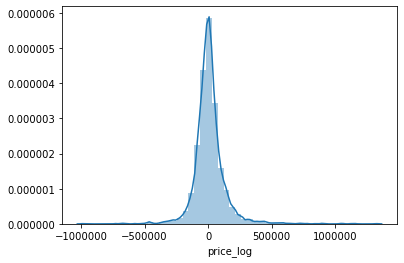

In [307]:
sns.distplot(residuals)

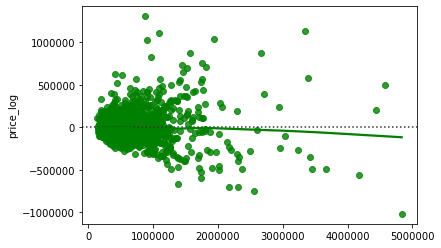

In [308]:
sns.residplot(y_test_pred, np.exp(y_test), lowess=True, color="g")

In [309]:
df.to_csv('data_with_all_features.csv')

My residuals look very normally distributed, they have a slight upward trend but its pretty minor. They are centered around zero which seems like a good thing. 

In [310]:
#instantiate a linear regression object
lm_final = LinearRegression()

#fit the linear regression to the data
lm_final = lm_final.fit(df[factors], df['price_log'])
lm_final

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [311]:
import pickle


pickle_out = open("model.pickle","wb")
pickle.dump(lm_final, pickle_out)
pickle_out.close()